### Imports

In [1]:
%%capture
try:
    import faiss
except ImportError:
    print("Installing faiss-cpu and unsloth...")
    !pip install faiss-cpu unsloth

In [2]:
import random

import numpy as np
import torch

seed = 47
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


### Dataset

In [3]:
import gzip
import os
import shutil
import urllib.request

from tqdm import tqdm

url = "https://huggingface.co/datasets/sentence-transformers/embedding-training-data/resolve/main/yahoo_answers_question_answer.jsonl.gz"

if not os.path.exists("yahoo_answers_question_answer.jsonl"):
    urllib.request.urlretrieve(url, "yahoo_answers_question_answer.jsonl.gz")
    with gzip.open("yahoo_answers_question_answer.jsonl.gz", "rb") as f_in:
        with open("yahoo_answers_question_answer.jsonl", "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)


In [4]:
import json

data = []
with open("yahoo_answers_question_answer.jsonl", "r") as f:
    for line in f:
        data.append(json.loads(line))

print(f"Loaded {len(data)} records from the dataset.")
print(data[1])

Loaded 681164 records from the dataset.
['long-distance trail throughout CA', 'i hear that the mojave road is amazing!<br />\\nsearch for it online.']


In [5]:
data_short = data[:300]
data_medium = data[:1500]

### Load models

In [6]:
import faiss
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline
from unsloth import FastLanguageModel

gen_model, gen_tokenizer = FastLanguageModel.from_pretrained(
    # model_name = "unsloth/Meta-Llama-3.1-8B-Instruct",
    # model_name = "unsloth/Llama-3.2-3B-Instruct",
    model_name="unsloth/Llama-3.2-1B-Instruct",
    # load_in_4bit = True,
    device_map="cuda:0",
)

sim_model = SentenceTransformer(
    "sentence-transformers/all-mpnet-base-v2", device="cuda:1"
)

retriever = SentenceTransformer("intfloat/e5-large-v2", device="cuda:1")

summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device="cuda:1")


2025-06-21 13:35:12.124715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750512912.152315    3079 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750512912.160478    3079 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_3079/1333624964.py:4: UserWarning: WARNING: Unsloth should be imported before transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.6.3: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Device set to use cuda:1


### Utility functions for generating and processing data

In [7]:
def generate_response(question):
    prompt = (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\nAnswer the following question concisely.\n\n"
        "### Input:\n" + question.strip() + "\n\n"
        "### Response:\n"
    )
    inputs = gen_tokenizer(prompt, return_tensors="pt").to(gen_model.device)
    outputs = gen_model.generate(**inputs, max_new_tokens=128)
    return (
        gen_tokenizer.decode(outputs[0], skip_special_tokens=True)
        .split("Answer:")[-1]
        .strip()
    )


def retrieve_topk(contexts, index, question, k=20):
    query_emb = retriever.encode([question], show_progress_bar=False)
    _, indices = index.search(np.array(query_emb), k)
    return [contexts[i] for i in indices[0]]


def recall_at_k(contexts, index, k):
    hits = 0
    for i, (q, a) in enumerate(data_medium):
        ctxs = retrieve_topk(contexts, index, q, k)
        if a in ctxs:
            hits += 1
    return hits / len(data_medium)


def summarize_contexts(
    contexts,
    max_length_per_context=30,
    min_length_per_context=10,
    model_max_length=1024,
    batch_size=4,
):
    summarized = []

    for i in range(0, len(contexts), batch_size):
        batch = contexts[i : i + batch_size]
        batch_clean = [c.strip()[:2048] for c in batch]  # Trim long inputs

        inputs = summarizer.tokenizer(
            batch_clean,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=model_max_length,
        ).to(summarizer.device)
        input_lengths = [len(x) for x in inputs["input_ids"]]

        summaries = []
        for j, context in enumerate(batch_clean):
            input_len = input_lengths[j]
            # Dynamic max/min length for each sample
            dyn_max = min(max_length_per_context, max(20, int(input_len * 0.4)))
            dyn_min = min(min_length_per_context, int(dyn_max * 0.5))

            if input_len < dyn_max:
                summaries.append(context)
            else:
                out = summarizer(
                    context,
                    max_length=dyn_max,
                    min_length=dyn_min,
                    do_sample=False,
                    truncation=True,
                )[0]["summary_text"].strip()
                summaries.append(out)

        summarized.extend(summaries)

    return summarized


def generate_with_context(question, contexts):
    # contexts = summarize_contexts(contexts)
    context = "\n".join(contexts)
    prompt = (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\nAnswer the following question concisely. You can use provided context.\n\n"
        f"### Input:\nContext:\n{context}\n\nQuestion: {question.strip()}\n\n"
        "### Response:\n"
    )
    inputs = gen_tokenizer(
        prompt, return_tensors="pt", max_length=2048, truncation=True
    ).to(gen_model.device)
    outputs = gen_model.generate(**inputs, max_new_tokens=128)
    return (
        gen_tokenizer.decode(outputs[0], skip_special_tokens=True)
        .split("Answer:")[-1]
        .strip()
    )


def judge_score(question, reference, generated):
    # Encode both answers (reference and generated)
    ref_emb = sim_model.encode(
        reference, convert_to_tensor=True, show_progress_bar=False
    )
    gen_emb = sim_model.encode(
        generated, convert_to_tensor=True, show_progress_bar=False
    )

    # Calculate semantic similarity between reference and generated answers
    similarity = util.pytorch_cos_sim(ref_emb, gen_emb).item()

    # Return [negative_score, positive_score] format
    return [1.0 - similarity, similarity]

### Generation

In [8]:
FastLanguageModel.for_inference(gen_model)

no_context_results = []

for q, a in tqdm(data_short):
    response = generate_response(q)
    score = judge_score(q, a, response)
    no_context_results.append((q, a, response, score))


100%|██████████| 300/300 [12:10<00:00,  2.43s/it]


In [9]:
contexts = [a for _, a in data_medium]  # відповіді як база знань

context_embeddings = retriever.encode(
    contexts, convert_to_numpy=True, show_progress_bar=False
)
index = faiss.IndexFlatL2(context_embeddings.shape[1])
index.add(context_embeddings)


In [10]:
FastLanguageModel.for_inference(gen_model)

rag_results = []

for q, a in tqdm(data_short):
    ctxs = retrieve_topk(contexts, index, q, k=5)
    rag_ans = generate_with_context(q, ctxs)
    score = judge_score(q, a, rag_ans)
    rag_results.append((q, a, rag_ans, score))


100%|██████████| 300/300 [13:52<00:00,  2.78s/it]


### Analize and visualize

In [11]:
# Evaluate recall for multiple K values
recall_values = {}
for k in [5, 10, 20, 30]:
    recall_values[k] = recall_at_k(contexts, index, k)
    print(f"Recall@{k}: {recall_values[k]:.4f}")

Recall@5: 0.6373
Recall@10: 0.6973
Recall@20: 0.7527
Recall@30: 0.7720


In [12]:
# Analyze judge scores and compare no-context vs RAG answers
import matplotlib.pyplot as plt
import numpy as np

# Extract scores from results
no_context_scores_array = np.array([score for _, _, _, score in no_context_results])
rag_scores_array = np.array([score for _, _, _, score in rag_results])

# Calculate average scores
avg_no_context = np.mean(no_context_scores_array[:, 1])
avg_rag = np.mean(rag_scores_array[:, 1])

print(f"Average judge score (No Context): {avg_no_context:.4f}")
print(f"Average judge score (RAG): {avg_rag:.4f}")
print(f"Improvement with RAG: {(avg_rag - avg_no_context) / avg_no_context * 100:.2f}%")

# Count how many times RAG is better than no context
better_count = sum(
    1
    for i in range(len(data_short))
    if rag_scores_array[i, 1] > no_context_scores_array[i, 1]
)
print(
    f"RAG produces better answers in {better_count}/{len(data_short)} cases ({better_count / len(data_short) * 100:.2f}%)"
)

Average judge score (No Context): 0.3341
Average judge score (RAG): 0.4165
Improvement with RAG: 24.66%
RAG produces better answers in 195/300 cases (65.00%)


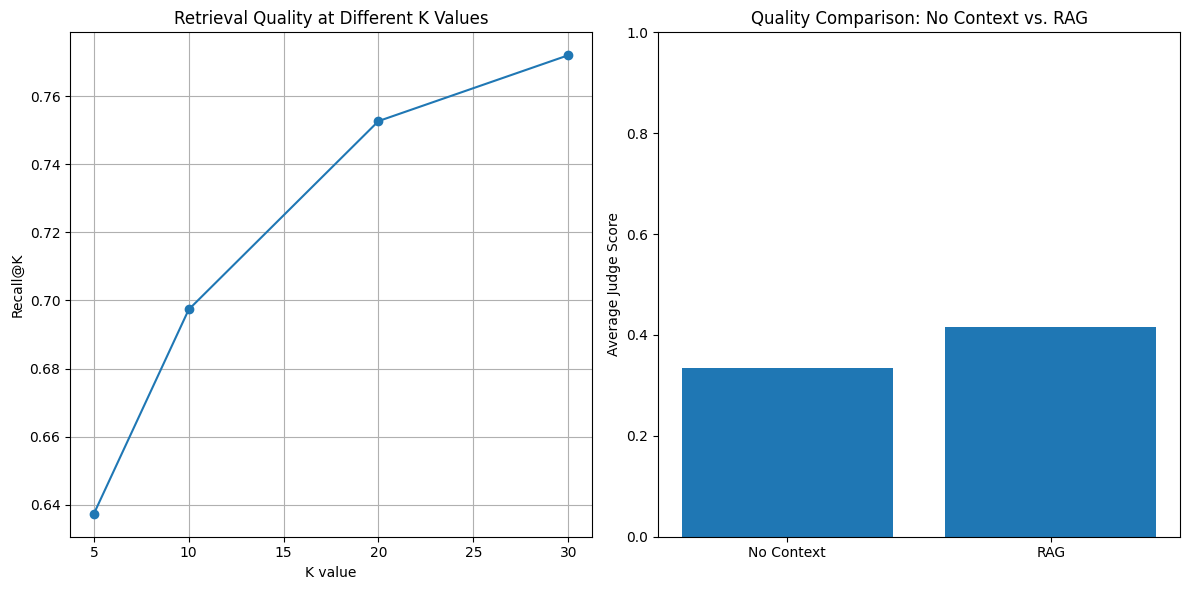

In [13]:
# Visualize the results
plt.figure(figsize=(12, 6))

# Plot 1: Recall@K
plt.subplot(1, 2, 1)
plt.plot(list(recall_values.keys()), list(recall_values.values()), marker="o")
plt.xlabel("K value")
plt.ylabel("Recall@K")
plt.title("Retrieval Quality at Different K Values")
plt.grid(True)

# Plot 2: Judge scores comparison
plt.subplot(1, 2, 2)
labels = ["No Context", "RAG"]
scores = [avg_no_context, avg_rag]
plt.bar(labels, scores)
plt.ylabel("Average Judge Score")
plt.title("Quality Comparison: No Context vs. RAG")
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

In [14]:
# Show examples of improvements
print("Examples where RAG significantly improved the answer:")
shown = 0
for i in range(len(data_short)):
    improvement = rag_scores_array[i, 1] - no_context_scores_array[i, 1]
    if improvement > 0.3:
        print(f"\nQuestion: {data_short[i][0]}")
        print(f"Reference Answer: {data_short[i][1]}")
        print(f"No Context Answer: {no_context_results[i][2]}")
        print(f"RAG Answer: {rag_results[i][2]}")
        print(f"No Context Score: {no_context_scores_array[i, 1]:.4f}")
        print(f"RAG Score: {rag_scores_array[i, 1]:.4f}")
        print(f"Improvement: {improvement:.4f}")
        print("-" * 80)
        shown += 1
        if shown >= 3:
            break

Examples where RAG significantly improved the answer:

Question: the prices of rent and the price of buying does not make sense to me, mostly the rent will not cover the mortgage . Is it better to rent a house or to buy?
Reference Answer: renting vs buying depends on your goals. <br />\ngenerally thinking is that buying is better b/c the payments that would go into the rent start building equity in your home. the govt also incentivizes you to buy by making your property tax payments and mortgage interest payments tax deductible.\nhaving said that current housing status in the bay area is such that housing cost to purchase is relatively high and rental prices (compared to ownership cost) are relatively low (relative to the rest of the country). it makes lese sense to buy vs. other places.\nbottom line you should base your decision on whether you think the market will keep going up or not. the other numbers tend to even out, the main gain or loss in buying comes from appreciation/depreci